<a href="https://colab.research.google.com/github/aarmentamna/machine_learning_advance/blob/main/TC5033_Activity3b_42.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Maestría en Inteligencia Artificial Aplicada**
### **Curso: ADVANCED MACHINE LEARNING METHODS**
## Tecnológico de Monterrey
### Dr. José Antonio Cantoral Ceballos

## Activity Week 7
### Text Classification using RNNs and AG_NEWS dataset in PyTorch

*TEAM MEMBERS:*

*   Roberto Romero Vielma - A00822314
*   José Javier Granados Hernández - A00556717
*   Aquiles Yonatan Armenta Hernandez - A01793252
*   Alan Avelino Fernández Juárez - A00989308

## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy function (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Install library commands

In [1]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [2]:
# Install libraries alternative with pip

# !pip install 'portalocker>=2.0.0'
# !pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2
# !pip install torchdata
# !pip install torchtext

### Import libraries
1. `import numpy as np`: The 'numpy' library is imported and aliased as 'np' for numerical operations.

2. `import torch`: The PyTorch library is imported for deep learning tasks.

3. `from torchtext.datasets import AG_NEWS`: The 'AG_NEWS' dataset is imported from the 'torchtext.datasets' module.

4. `from torch.utils.data import DataLoader`: The 'DataLoader' class is imported from the 'torch.utils.data' module.

5. `from torch.utils.data.dataset import random_split`: The 'random_split' function is imported from the 'torch.utils.data.dataset' module.

6. `from torchtext.data.utils import get_tokenizer`: The 'get_tokenizer' function is imported from 'torchtext.data.utils'.

7. `from torchtext.vocab import build_vocab_from_iterator`: The 'build_vocab_from_iterator' function is imported from 'torchtext.vocab'.

8. `from torchtext.data.functional import to_map_style_dataset`: The 'to_map_style_dataset' function is imported from 'torchtext.data.functional'.

9. `from torch import nn`: The 'nn' module from PyTorch is imported for building neural network layers.

10. `from torch.nn import functional as F`: The 'F' module from 'torch.nn' is imported for functional operations in neural networks.

11. `import gc`: The 'gc' (garbage collector) module is imported for memory management and cleanup.

12. `import matplotlib.pyplot as plt`: Matplotlib's pyplot is imported for data visualization.

13. `import seaborn as sns`: Seaborn is imported for data visualization.

14. `from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc`: Import for model performance metrics.

15. `from sklearn.preprocessing import label_binarize`: Imported function to give labels a string format.

The code prepares the environment by importing the required libraries, making them available for further tasks such as data preprocessing, model building, and evaluation, including the plotting of confusion matrices using 'scikitplot.'

In [3]:
# Install 'portalocker' library with a minimum version requirement of 2.0.0 using pip.
!pip install portalocker>=2.0.0

In [4]:
import numpy as np # Import the 'numpy' library and alias it as 'np' for numerical operations.

# PyTorch libraries
import torch # Import the PyTorch library for deep learning tasks.
from torchtext.datasets import AG_NEWS # Import the 'AG_NEWS' dataset from the 'torchtext.datasets' module.

# Dataloader library
from torch.utils.data import DataLoader # Import the 'DataLoader' class from the 'torch.utils.data' module.
from torch.utils.data.dataset import random_split # Import the 'random_split' function from the 'torch.utils.data.dataset' module.

# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer # Import the 'get_tokenizer' function from 'torchtext.data.utils'.
from torchtext.vocab import build_vocab_from_iterator # Import 'build_vocab_from_iterator' function from 'torchtext.vocab'.
from torchtext.data.functional import to_map_style_dataset # Import the 'to_map_style_dataset' function from 'torchtext.data.functional'.


# Neural Layers
from torch import nn # Import the 'nn' module from PyTorch for building neural network layers.
from torch.nn import functional as F # Import the 'F' module from 'torch.nn' for functional operations in neural networks.


import gc # Import the 'gc' (garbage collector) module for memory management and cleanup.

# Plot a confusion matrix
import matplotlib.pyplot as plt # Import Matplotlib pyplot for data vizualization
import seaborn as sns # Import seaborn also for data visualization
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc # Import for model performance metrics
from sklearn.preprocessing import label_binarize # Imported function to give labels a string format


### GPU, CPU Selection
This code determines the computation device (CPU or GPU) for PyTorch tensor operations. It follows these steps:

1. It checks if a GPU (NVIDIA CUDA-compatible) is available using `torch.cuda.is_available()`.

2. If a GPU is available, it sets the `device` variable to 'cuda', indicating GPU usage.

3. If a GPU is not available, it attempts to check for a Mac M Series GPU using 'mps' as the device name (specific to the environment).

4. If neither a GPU nor 'mps' is available, it falls back to using the CPU as the default computation device.

5. Finally, it prints the selected device: 'cuda' for GPU, 'mps' for Mac M Series (environment-specific), or 'cpu' for CPU.

It's important to validate and adapt the 'mps' part for your specific use case as it might not be a standard PyTorch device name.

The code can be used in Jupyter Notebook to determine the computation device for PyTorch operations.


In [5]:
# Check if a CUDA-compatible GPU is available; if yes, use CUDA, otherwise, use MPS or CPU
# Check for Nvidia GPU first
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    try:
        # Check for existance of Mac M Series GPU
        device = torch.device('mps')
    except:
        # Default computation device -> CPU
        device = torch.device('cpu')
print(device)

cuda


### Get the train and the test datasets and dataloaders
The following code demonstrates various steps in data preprocessing and dataset splitting for a machine learning or deep learning task.

#### Data Loading and Dataset Splitting

1. **Load the AG_NEWS dataset and Split:** Initially, the AG_NEWS dataset is loaded and then split into two datasets: `train_dataset` and `test_dataset`.

2. **Convert to Map-Style Datasets:** Both the training and testing datasets are converted to map-style datasets using the `to_map_style_dataset` function. Map-style datasets are a common format for data processing in PyTorch. One of the advantages of having this format is to have indexable content; such as in lists `dataset[0]`

#### Tokenization and Vocabulary Building

3. **Tokenization Setup:** A tokenizer is defined using the 'basic_english' configuration, which is suitable for processing English text.

4. **Token Yielding Function:** A function named `yield_tokens` is defined to extract tokens from the given data. It iterates through the data and tokenizes the text using the `tokeniser`.

5. **Vocabulary Building:** A vocabulary is built from the tokens yielded by the `yield_tokens` function, with the special token "<unk>" used to represent unknown words. The vocabulary is created using the `build_vocab_from_iterator` function.

6. **Default Index Set:** The default index of the vocabulary is set to "<unk>" to handle out-of-vocabulary words. If a token is not found in the vocabulary, it defaults to "<unk>."

#### Tokenization and Data Splitting

7. **Tokenization of Input Text:** The input text, "Welcome to TE3007," is tokenized using the 'tokeniser.'

8. **Validation Dataset Size Calculation:** The code calculates the number of samples for the training and validation datasets. It reserves 90% of the data for training and assigns the remaining for validation.

9. **Training and Validation Split:** The training dataset is split into two sets, `train_dataset` (containing `NUM_TRAIN` samples for training) and `val_dataset` (containing `NUM_VAL` samples for validation).

#### Dataset Lengths

10. **Dataset Lengths:** Finally, the lengths of the training, validation, and test datasets are printed to provide insights into the size of each dataset. This information is crucial for data preparation and model training.

This code demonstrates essential steps in data preprocessing, including tokenization, vocabulary building, and dataset splitting, to prepare the data for subsequent deep learning tasks.

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [6]:
# Load the AG_NEWS dataset and split it into training and testing datasets
train_dataset, test_dataset = AG_NEWS()
# Convert the datasets to map-style datasets
# If any error shows in this cell, delete runtime and run all the notebook again
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [7]:
# See the shapes of the data
print('Size of datasets:', train_dataset.__len__(), test_dataset.__len__())
# See the top and bottom of one data set
print('Top and bottom of train data set:')
print(train_dataset[0])
print(train_dataset[-1])

Size of datasets: 120000 7600
Top and bottom of train data set:
(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")
(2, 'Nets get Carter from Raptors INDIANAPOLIS -- All-Star Vince Carter was traded by the Toronto Raptors to the New Jersey Nets for Alonzo Mourning, Eric Williams, Aaron Williams, and a pair of first-round draft picks yesterday.')


In [8]:
# Define a tokenizer using the 'basic_english' configuration
tokeniser = get_tokenizer('basic_english')

# Define a function to yield tokens from the given data
def yield_tokens(data):
    for _, text in data:
        # Tokenize the text using the previously defined 'tokeniser'
        yield tokeniser(text)

In [9]:
# Build a vocabulary from the tokens yielded by the 'yield_tokens' function on the training dataset
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
# The 'specials' argument specifies special tokens, and "<unk>" is used for unknown words.

# Set the default index of the vocabulary to "<unk>" (unknown) token
vocab.set_default_index(vocab["<unk>"])
# This ensures that if a token is not found in the vocabulary, it defaults to "<unk>" for handling out-of-vocabulary words.

In [10]:
# Tokenize the input text using the 'tokeniser'
tokens = tokeniser('Welcome to TE3007')
# Print the original tokens and their corresponding indices
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [11]:
# Calculate the number of samples for the training dataset by taking 90% of the entire dataset.
NUM_TRAIN = int(len(train_dataset) * 0.9)

# Calculate the number of samples for the validation dataset by subtracting the training dataset size from the total dataset size.
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [12]:
# Split the training dataset into training and validation datasets
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

# 'train_dataset' now contains NUM_TRAIN samples for training.
# 'val_dataset' now contains NUM_VAL samples for validation.

In [13]:
# Print the lengths of the training, validation, and test datasets
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


### Batch Collation Function

1. **Splitting Labels and Text Data:** The function starts by receiving a batch of data. It separates the labels (y) and text data (x) using the `list(zip(*batch))` operation.

2. **Tokenization and Numerical Conversion:** It then tokenizes the text data using a previously defined tokenizer (`tokeniser`) and converts the tokens to numerical representations using a vocabulary (`vocab`).

3. **Padding and Truncation:** To ensure that all sequences have the same length for efficient processing, the function checks the length of each sequence. If a sequence is shorter than a predefined maximum length (`max_tokens`), it is padded with zeros to match the maximum length. If it's longer, it's truncated to the maximum length.

4. **Data Type Conversion:** Finally, the function converts the processed data into PyTorch tensors. The text data is represented as a tensor with data type `torch.int32`, and the labels are adjusted by subtracting 1 from them and represented as tensors with the same data type.

In [14]:
# Define a function for batch collation
def collate_batch(batch):
    # Split the batch into labels (y) and text data (x)
    y, x = list(zip(*batch))

    # Tokenize the text data and convert to numerical representations using the vocabulary
    x = [vocab(tokeniser(text)) for text in x]

    # Pad or truncate sequences to a maximum length (max_tokens)
    x = [t + ([0] * (max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Convert the tokenized and padded/truncated sequences to PyTorch tensors
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [15]:
# Define a list of labels for the AG_NEWS dataset
labels = ["World", "Sports", "Business", "Sci/Tech"]

# Define the maximum number of tokens allowed in a sequence
max_tokens = 50

# Define the batch size for training and data processing
BATCH_SIZE = 256

In [16]:
# Create a DataLoader for the training dataset with a specified batch size and data processing function
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True)

# Create a DataLoader for the validation dataset with the same batch size and processing function
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True)

# Create a DataLoader for the test dataset with the same batch size and processing function
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True)

### Let us build our RNN model
The following code defines a custom recurrent neural network (RNN) model class named `RNN_Model_1` for sequence classification tasks.

#### Model Architecture

1. **Initialization:** In the constructor (`__init__`), the model is initialized with the following parameters:
    - `embed_size`: The size of the word embedding vectors.
    - `hidden`: The number of hidden units in the RNN layer.
    - `layers`: The number of stacked RNN layers.
    - `num_classes`: The number of classes in the classification task.

2. **Embedding Layer:** An embedding layer is created using the `nn.Embedding` module. This layer converts input tokens to dense vectors. The `num_embeddings` parameter is set to the length of the vocabulary (`len(vocab)`) to match the vocabulary size, and the `embedding_dim` is set to the specified `embed_size`.

3. **RNN (GRU) Layer:** An RNN layer, specifically a Gated Recurrent Unit (GRU) layer, is created using `nn.GRU`. It takes the embedded input and processes it through recurrent layers. The `input_size` is set to `embed_size`, the `hidden_size` to `hidden`, the `num_layers` to `layers`, and `batch_first` is set to `True`.

4. **Fully Connected Layer:** A fully connected layer is created using `nn.Linear`. It is used for the final classification. The `input_size` is `hidden`, and the `output_size` is `num_classes`.

### Forward Pass

The `forward` method specifies how data is passed through the model:
1. The input `x` is first cast to `torch.int64` to ensure the correct data type.
2. The input sequence is embedded using the previously defined embedding layer.
3. The embedded sequence is passed through the GRU layer to capture sequential information.
4. The output from the RNN layer is extracted from the last time step.
5. Finally, the output is passed through the fully connected layer for classification.

This model architecture is designed for sequence classification tasks, such as text classification, where the input sequence is processed to make class predictions.


In [17]:
# Define the embedding size for word embeddings in the model
EMBEDDING_SIZE = 100

# Define the number of neurons in each hidden layer of the neural network
NEURONS = 64

# Define the number of layers in the neural network
LAYERS = 2

# Define the number of classes in the classification task
NUM_CLASSES = len(labels)

In [18]:
# Define a custom RNN model class (RNN_Model_1)
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()

        # Create an embedding layer for converting input tokens to dense vectors
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)
        # 'vocab' should be defined previously and represents the vocabulary for the dataset.

        # Create an RNN (GRU) layer for sequence processing
        self.rnn = nn.GRU(input_size=embed_size, hidden_size=hidden, num_layers=layers, batch_first=True)

        # Create a fully connected layer for classification
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):
        x = x.to(torch.int64)  # Ensure the input is of type 'torch.int64'

        # Embed the input sequence
        embedded = self.embedding_layer(x)

        # Pass the embedded sequence through the RNN layer
        output, _ = self.rnn(embedded)

        # Extract the output at the last time step of the sequence
        output = output[:, -1, :]

        # Pass the output through the fully connected layer for classification
        output = self.fc(output)

        return output

### Accuracy

The code below defines a function named `accuracy` for calculating the accuracy of a given model on a specified data loader. The function returns the accuracy as a floating-point value.

#### Accuracy Calculation

1. **Initialization:** Inside the `accuracy` function, two variables are initialized:
   - `num_correct`: A counter for the number of correctly predicted instances.
   - `num_total`: A counter for the total number of instances.

2. **Model Evaluation:** The model is set to evaluation mode using `model.eval()`. This is important for ensuring that layers like dropout and batch normalization behave differently during evaluation compared to training.

3. **Device Configuration:** The model is moved to the specified device (e.g., GPU or CPU) using `model.to(device=device)` to ensure that calculations are performed on the selected device.

4. **Accuracy Computation:** The function iterates through the data loader. For each batch of data:
   - The input (`x`) and target labels (`y`) are moved to the same device as the model with appropriate data types.
   - The model is used to predict scores for the input data (`scores`).
   - The predictions with the highest scores are obtained using `scores.max(dim=1)`.
   - Correct predictions are counted by comparing the predictions to the true labels (`y`), and the number of correct predictions is added to `num_correct`.
   - The total number of instances in the batch is added to `num_total`.

5. **Accuracy Calculation:** The final accuracy is computed by dividing the number of correct predictions (`num_correct`) by the total number of instances (`num_total`). The result is returned as a floating-point value.


In [19]:
# Define a function for calculating the accuracy of a given model on a specified data loader
def accuracy(model, loader):
    num_correct = 0  # Initialize a counter for the number of correctly predicted instances
    num_total = 0  # Initialize a counter for the total number of instances

    model.eval()  # Set the model to evaluation mode
    model = model.to(device=device)  # Move the model to the specified device

    with torch.no_grad():  # Disable gradient tracking during inference
        for x, y in loader:  # Iterate through the data loader
            x = x.to(device=device, dtype=torch.float32)  # Move input data to the device with the appropriate data type
            y = y.to(device=device, dtype=torch.long)  # Move target labels to the device with the appropriate data type
            scores = model(x)  # Use the model to predict scores for the input data
            _, predictions = scores.max(dim=1)  # Find the class with the highest score for each instance
            num_correct += (predictions == y).sum()  # Count the number of correct predictions in the batch
            num_total += predictions.size(0)  # Add the total number of instances in the batch to the counter

    return float(num_correct / num_total)  # Compute and return the accuracy as a floating-point value

### Training

The following code defines a training function for deep learning model. This function is responsible for training the model over multiple epochs using the specified data loader and optimizing the model's parameters using an optimizer.

### Function Overview

The `train` function has the following components:

1. **Model and Device Configuration:**
   - The function starts by moving the model to the specified device (CPU or GPU) using `model.to(device=device)`. This ensures that all computations occur on the selected hardware.
   
2. **Epochs Loop:**
   - The training process is executed for a specified number of training epochs. The outer loop iterates over each epoch using `for epoch in range(epochs)`.

3. **Data Loading:**
   - Within each epoch, the inner loop iterates over the training data using `for i, (x, y) in enumerate(train_loader)`. This loop allows the model to process the entire training dataset in batches.

4. **Training Mode:**
   - The model is set in training mode with `model.train()`. This is necessary to enable gradient computation and backpropagation during training.

5. **Data Preparation:**
   - Input data (`x`) is moved to the specified device with the appropriate data type (`dtype=torch.float32`), and target labels (`y`) are also moved to the device with the appropriate data type (`dtype=torch.long`).

6. **Forward Pass and Loss Computation:**
   - The model is used to predict scores for the input data (`scores`).
   - The cross-entropy loss is computed using `F.cross_entropy`. This loss quantifies the error between predicted scores and true labels.

7. **Gradient Computation:**
   - The gradients are cleared to prevent gradient accumulation with `optimiser.zero_grad()`.
   - Backpropagation is performed using `cost.backward()` to compute gradients.

8. **Parameter Update:**
   - The model's parameters are updated using the optimizer (`optimiser`) with `optimiser.step()`.

9. **Validation and Logging:**
   - After each epoch, the accuracy of the model on the validation set is calculated using the `accuracy` function.
   - Training statistics such as the current epoch, cost (loss), and accuracy are printed to monitor the training progress using `print(f'Epoch: {epoch}, cost: {cost.item()}, accuracy: {acc}.')`.

This `train` function is a fundamental component for training machine learning models. It encapsulates the process of forward and backward passes, parameter updates, and performance monitoring over multiple training epochs.


In [20]:
# Define a training function for a machine learning model.
def train(model, optimizer, epochs=100):
    model = model.to(device=device)  # Move the model to the specified device (CPU or GPU).

    for epoch in range(epochs):  # Iterate over the specified number of training epochs.
        for i, (x, y) in enumerate(train_loader):  # Loop through the training data.
            model.train()  # Set the model in training mode to enable gradient computation.
            x = x.to(device=device, dtype=torch.float32)  # Move input data to the specified device with the appropriate data type.
            y = y.to(device=device, dtype=torch.long)  # Move target labels to the specified device with the appropriate data type.
            scores = model(x)  # Get the model's predicted scores.
            cost = F.cross_entropy(input=scores, target=y)  # Calculate the cross-entropy loss.
            optimizer.zero_grad()  # Zero the gradients to prevent gradient accumulation.
            cost.backward()  # Perform backpropagation to compute gradients.
            optimizer.step()  # Update model parameters using the optimizer.

        acc = accuracy(model, val_loader)  # Calculate the accuracy of the model on the validation set.
        print(f'Epoch: {epoch+1}/{epochs}, Loss: {cost.item()}, Accuracy: {acc}') # Print training statistics including the current epoch, loss, and accuracy on the validation set.

In [21]:
# Set the number of training epochs to 20 for model training.
epochs = 20

# Set the learning rate (lr) to 0.001 for the Adam optimizer.
lr = 0.001

# Create an instance of the RNN model (RNN_Model_1) with specified parameters.
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)

# Initialize the optimizer (Adam) for updating the model's parameters with the specified learning rate (lr).
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)

In [22]:
# Train the RNN model using the provided optimizer and the specified number of training epochs.
train(rnn_model, optimiser, epochs)

Epoch: 1/20, Loss: 0.3506190776824951, Accuracy: 0.8727499842643738
Epoch: 2/20, Loss: 0.3054317831993103, Accuracy: 0.8928333520889282
Epoch: 3/20, Loss: 0.24265992641448975, Accuracy: 0.9041666388511658
Epoch: 4/20, Loss: 0.2136060744524002, Accuracy: 0.9077500104904175
Epoch: 5/20, Loss: 0.25163534283638, Accuracy: 0.9111666679382324
Epoch: 6/20, Loss: 0.127325639128685, Accuracy: 0.909333348274231
Epoch: 7/20, Loss: 0.10215054452419281, Accuracy: 0.9071666598320007
Epoch: 8/20, Loss: 0.022748669609427452, Accuracy: 0.9053333401679993
Epoch: 9/20, Loss: 0.10070691257715225, Accuracy: 0.9048333168029785
Epoch: 10/20, Loss: 0.031432200223207474, Accuracy: 0.9009166359901428
Epoch: 11/20, Loss: 0.0470125786960125, Accuracy: 0.9040833115577698
Epoch: 12/20, Loss: 0.015360749326646328, Accuracy: 0.8995000123977661
Epoch: 13/20, Loss: 0.010043160989880562, Accuracy: 0.9020000100135803
Epoch: 14/20, Loss: 0.045509129762649536, Accuracy: 0.8994166851043701
Epoch: 15/20, Loss: 0.021764293313

<span style='color:red'>**WARNING: IF the device selected is MPS, the accuracy and losses can be set to NAN. This can be due to a conflict in the used library versions in pytorch. Make sure to be using the latests.**</span>

In [23]:
# Print and display the test accuracy of the trained RNN model on the test dataset with four decimal places.
print(f'accuracy: {accuracy(rnn_model, test_loader):.4f}')

accuracy: 0.8938


### **Sample_text Function**

The `sample_text` function is designed to display text samples and their corresponding predictions generated by a natural language processing model. Here's a breakdown of how it works:

- **Model Evaluation**: The function sets the model in evaluation mode, which ensures that the model's parameters are not updated during inference.

- **Storage of Predicted Results**: An empty list named `predicted_results` is initialized to store the predicted results, and a counter, `sample_count`, is established to keep track of the number of displayed samples.

- **Iteration Through Test Data**: The function iterates through the test data using a DataLoader. For each data sample, it performs the following steps:

  - **Data Preparation**: It moves the input data to the specified computing device and changes its data type.

  - **Inference with Gradient Tracking Disabled**: The function uses the model to predict scores for the input data, while disabling gradient tracking for efficiency.

  - **Determination of Predicted Classes**: It identifies the predicted classes by selecting the index of the highest score for each sample.

  - **Random Sample Selection**: The function randomly selects a sample index from the available index range.

  - **Text Retrieval**: It retrieves the original text corresponding to the selected sample from the test dataset.

  - **Class Prediction Retrieval**: The predicted class corresponding to the selected index is obtained.

  - **Sample Count Update**: The sample counter is incremented to keep track of the number of displayed samples.

  - **Display**: It displays the original text and the predicted class for the sample.

  - **Controlled Termination**: The loop exits when the desired number of samples has been displayed, as controlled by the `num_samples` parameter.


In [24]:
def sample_text(model, test_loader, num_samples=1):
    model.eval()  # Set the model in evaluation mode.
    predicted_results = []  # Initialize a list to store predicted results.
    sample_count = 0  # Initialize a counter for the displayed samples.

    for x, _ in test_loader:  # Iterate through the test_loader.
        x = x.to(device=device, dtype=torch.int32)  # Move input data to the specified device.
        with torch.no_grad():  # Disable gradient tracking for inference.
            scores = model(x)  # Use the model to predict scores for the input text.

        predicted_classes = scores.argmax(dim=1)  # Find the predicted classes.

        random_index = np.random.randint(0, len(predicted_classes))  # Choose a random prediction.
        random_sample_text = test_loader.dataset[random_index][1]  # Get the original phrase from the test dataset.
        random_predicted_class = labels[predicted_classes[random_index].item()]  # Get the predicted class.

        sample_count += 1  # Increase the sample counter.

        print(f'Original text: {random_sample_text}')  # Display the original text.
        print(f'Prediction: {random_predicted_class}')  # Display the predicted class.

        if sample_count >= num_samples:
            break  # Exit the loop after displaying the specified number of samples.

In [25]:
sample_text(rnn_model, test_loader) # Testing sample_text function

Original text: Peace delegation leaves Najaf empty-handed as fighting continues BAGHDAD, Iraq - A national political conference #39;s bid to end the fighting in the Shiite Muslim holy city of Najaf appeared to have failed Tuesday. 
Prediction: Sci/Tech


### Function for Creating a Confusion Matrix and ROC Curve Metrics

This Python code defines a function to evaluate a classification model and generate a confusion matrix, classification report, and ROC (Receiver Operating Characteristic) curves for each class in the model's predictions. Let's break down the code step by step:

#### 1. Initialize Lists

- `true_labels`, `predicted_labels`, and `tested_phrases` are initialized as empty lists. These lists will be used to store the true labels, predicted labels, and tested phrases, respectively.

#### 2. Define the `create_confusion_matrix_metrics` Function

This function takes the following parameters:
- `model`: The trained PyTorch model.
- `data_loader`: The data loader for the test dataset.
- `class_names`: A list of class names.
- `device`: The device on which the model should run (e.g., GPU).

#### 3. Set Model to Evaluation Mode

- `model.eval()`: Sets the model to evaluation mode, which disables training-specific behaviors such as dropout.

#### 4. Initialize Arrays for ROC Curve Analysis

- `true_labels_bin` and `predicted_scores` are initialized as empty lists. These lists will be used to store binarized true labels and predicted scores, respectively, for ROC curve analysis.

#### 5. Disable Gradient Computation

- `with torch.no_grad()`: Disables gradient computation during evaluation to save memory and speed up inference.

#### 6. Iterate Over the Data Loader

- The function iterates through the test data loader, extracting input data and true labels for each batch. Data is moved to the specified device (e.g., GPU).

#### 7. Get Model Predictions

- Model predictions are obtained using `model(inputs)`. The predicted class with the highest probability is found using `torch.max(outputs, 1)`.

#### 8. Record True and Predicted Labels

- True labels and predicted labels are recorded in `true_labels` and `predicted_labels`, respectively. The `label_binarize` function is used to binarize true labels for ROC curve analysis.

#### 9. Generate and Plot the Confusion Matrix

- A confusion matrix is computed using scikit-learn's `confusion_matrix` function. It is then plotted using `sns.heatmap`.

#### 10. Print the Classification Report

- The classification report is printed using scikit-learn's `classification_report` function, providing detailed metrics for each class.

#### 11. Prepare Data for ROC Curve Analysis

- True labels and predicted scores are converted into NumPy arrays for ROC curve analysis.

#### 12. Compute ROC Curves and Areas

- ROC curves and areas under the curve (AUC) are computed for each class using scikit-learn's `roc_curve` and `auc` functions.

#### 13. Plot All ROC Curves

- ROC curves for each class are plotted, with class-specific AUC values displayed.

#### 14. Return Lists

- The function returns the `true_labels`, `predicted_labels`, and `tested_phrases` lists for further analysis if needed.

In [26]:
# Initialize empty lists to store true labels, predicted labels, and tested phrases
true_labels = []
predicted_labels = []
tested_phrases = []

# Define a function to create confusion matrix and ROC curve metrics
def create_confusion_matrix_metrics(model, data_loader, class_names, device):
    # Set the model in evaluation mode
    model.eval()

    # Initialize arrays for ROC curve analysis
    true_labels_bin = []
    predicted_scores = []

    # Disable gradient computation to save memory and speed up inference
    with torch.no_grad():
        # Iterate through the data loader
        for data in data_loader:
            # Extract input data and labels from the current batch
            inputs, labels = data
            # Move data to the specified device (e.g., GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Get the model output
            outputs = model(inputs)
            # Find the predicted class with the highest probability
            _, predicted = torch.max(outputs, 1)

            # Record the true and predicted labels in their respective lists
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

            # Record the scores for ROC curve analysis
            predicted_scores.extend(outputs.cpu().numpy())

            # Binarize true labels for ROC curve analysis
            true_labels_bin.extend(label_binarize(labels.cpu().numpy(), classes=range(len(class_names))))

    # Generate and plot the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print the classification report
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    # Prepare data for ROC curve analysis
    true_labels_bin = np.array(true_labels_bin)
    predicted_scores = np.array(predicted_scores)
    n_classes = len(class_names)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = {0:0.2f}) for label {1}'.format(roc_auc[i], class_names[i]))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    # Return the lists for further analysis if needed
    return true_labels, predicted_labels, tested_phrases



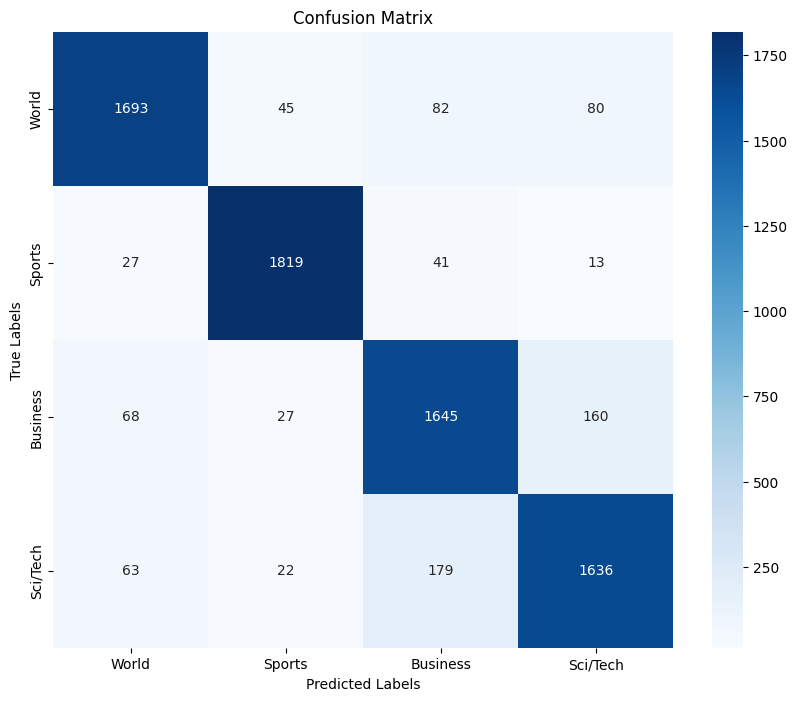

              precision    recall  f1-score   support

       World       0.91      0.89      0.90      1900
      Sports       0.95      0.96      0.95      1900
    Business       0.84      0.87      0.86      1900
    Sci/Tech       0.87      0.86      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



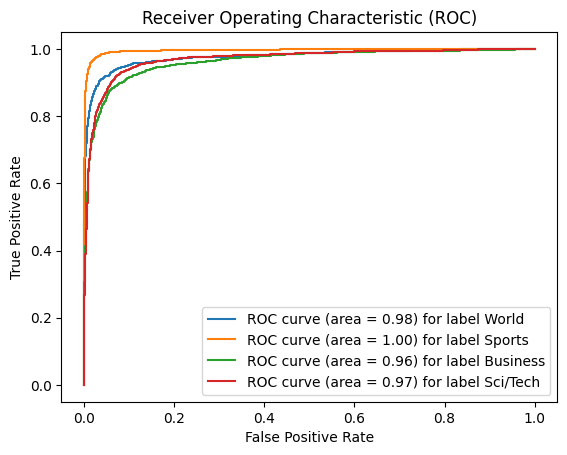

In [27]:
create_confusion_matrix_metrics(rnn_model, test_loader, labels, device); # Plot the confusion matrix, show the classification report and ROC curve

## Model Insights

Upon an extensive review of the model's aggregate performance, incorporating all categorical classes, it is observed that the model achieves an overall accuracy of 89%. This signifies that a substantial majority of predictions are accurate. Nevertheless, it is imperative to note that the classes 'Business' and 'Sci/Tech' exhibit a comparatively diminished prediction efficacy, with the 'Sci/Tech' category, in particular, demonstrating a pronounced disparity between precision and recall metrics. This discrepancy is a contributing factor to the elevated incidence of both false positives and false negatives within these categories.

The classification of the 'Sports' category is notably exceptional, showcasing superior results relative to other classes. To enhance the predictive capabilities of the remaining categories, the following strategic initiatives are recommended for consideration:

1. **Data Augmentation**: Implement advanced techniques to synthetically expand the training dataset, which can lead to improved model generalization.

2. **Hyperparameter Optimization**: Undertake a meticulous process of tuning hyperparameters to identify the most efficacious model configuration.

3. **Regularization Techniques**: Apply appropriate regularization methods to mitigate overfitting, thus ensuring the model's ability to generalize well to unseen data.

4. **Early Stopping**: Introduce early stopping in the training process to prevent overfitting by terminating the training when the validation metric ceases to improve.

These measures are anticipated to fortify the model's performance, particularly in the 'Business' and 'Sci/Tech' categories, thereby reducing the rate of misclassification and bolstering overall accuracy.


## Common Downsides and Mistakes with RNNs

Recurrent Neural Networks (RNNs) are a powerful class of neural networks, but they have several common downsides and potential mistakes that are important to be aware of when using them:

1. **Vanishing and Exploding Gradients:** RNNs can suffer from vanishing gradients, where the gradients become extremely small as they are backpropagated through time. This can make it challenging to train RNNs on long sequences. On the other hand, exploding gradients can also occur, where the gradients become extremely large, leading to numerical instability. Techniques like gradient clipping and using alternative RNN architectures (e.g., LSTMs and GRUs) can help mitigate these issues. Other techinques are batch normalization or using Resnet arquitechtures.

2. **Limited Context:** RNNs have a limited memory of previous time steps. They might not capture long-range dependencies in data efficiently. This limitation can be addressed by using more complex RNN architectures or other types of neural networks like Transformers for certain tasks.

3. **Inefficient Training:** Training RNNs can be computationally expensive, especially for deep networks and long sequences. It may require substantial resources, making it impractical for some applications. Training on GPUs or TPUs can help alleviate this issue.

4. **Data Preprocessing:** RNNs are sensitive to the quality of input data. Poorly preprocessed or noisy data can lead to suboptimal results. Data preprocessing, including text tokenization or sequence padding, is crucial.

5. **Sequential Computation:** RNNs are inherently sequential models, which makes parallelization challenging. Training and inference may be slower compared to models like CNNs.

6. **Overfitting:** RNNs are prone to overfitting, especially when dealing with small datasets. Regularization techniques like dropout and early stopping can help mitigate this issue.

7. **Hyperparameter Tuning:** Properly tuning the hyperparameters of an RNN, such as the learning rate, batch size, and architecture, can be a time-consuming task. It's essential to perform hyperparameter searches to achieve optimal performance.

8. **Lack of Interpretability:** RNNs are often considered black-box models, making it challenging to interpret how they arrive at a particular decision or prediction. Techniques like attention mechanisms and visualization tools can offer some insights.

9. **Model Selection:** Selecting the right RNN architecture (e.g., LSTM, GRU) for your task can be a crucial decision. It's not always clear which one will perform best, and it may require experimentation.

10. **Data Imbalance:** Handling imbalanced datasets with RNNs can be challenging. Careful handling of class imbalances and selection of appropriate evaluation metrics are necessary.

11. **Unidirectional Information:** By default, RNNs are unidirectional, meaning they only consider past context. In some tasks, it's crucial to consider future context as well. Bidirectional RNNs and Transformers can address this issue.

12. **Prone to Noise:** RNNs can be sensitive to noisy input data or data with missing values. Preprocessing and data cleaning are essential.

13. **Long Training Times:** Training large RNN models on long sequences can be time-consuming. Efficient hardware and distributed training can help, but it's still a consideration for resource-constrained setups.

To mitigate these issues and mistakes, it's important to understand the nature of your specific problem, experiment with different architectures and hyperparameters, preprocess your data carefully, and consider alternatives like Transformers for tasks where RNNs might not be the most suitable choice.


# **Conclusion**

In summary, the investigation into Text Classification utilizing Recurrent Neural Networks (RNNs) with the AG_NEWS dataset in PyTorch has offered a comprehensive exploration of fundamental concepts and practical applications in this advanced technology. The primary objectives were to comprehend the essentials of RNNs and their relevance in text classification, along with navigating the complexities of managing a real-world text dataset, AG_NEWS, within the PyTorch framework.

Ultimately, this exploration has expanded our perspectives in natural language processing and machine learning, providing us with the confidence and enhanced knowledge needed to tackle text classification challenges. Reflecting on the accomplished objectives, we acknowledge the importance of RNNs in processing sequential data and the practical significance of AG_NEWS as an indicative text dataset. This experience establishes a strong basis for further investigation and innovation in the ever-evolving fields of deep learning and text analysis.




